In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from nltk import FreqDist, word_tokenize, RegexpTokenizer, stem
from snowballstemmer import TurkishStemmer

import time
from string import punctuation
from pathlib import Path


In [100]:
class ProcessData():
    def __init__(self):
        print("Class INITIATED with cwd: {}".format(Path.cwd()))
        self._stopwords_tr = self.read_stopwords("./data/stopwords_tr.txt")
        self._stopwords_en = self.read_stopwords("./data/stopwords_en.txt")
        self._stemmer_en = stem.SnowballStemmer('english')
        self._stemmer_tr = TurkishStemmer()

    def read_file(self, excel_filename):
        excel_file_path = Path.joinpath(Path.cwd(), "data").joinpath(excel_filename)
        try:
            t0 = time.time()
            df = pd.read_excel(excel_file_path)
            print("File {0} Read Time: {1:.5f} sec.".format(excel_file_path, time.time() - t0))
            return df
        except Exception as e:
            print(e)

    def process_df_text(self, df):
        df_text = df.select_dtypes(include=["object"]).copy()
        # df_text.fillna("NULL", inplace=True)
        df_text.dropna(inplace=True)
        text_series = df_text.apply(lambda text: " ".join(text.values))
        text_series = text_series.apply(self.make_lowercase)
        text_series = text_series.apply(self.remove_puncts)
        text_series = text_series.apply(self.remove_stopwords)
        text_series = text_series.apply(self.remove_numbers)
        text_series = text_series.apply(self.stem_words)

        df_row_length = df_text.apply(self.row_length)

        return text_series, df_row_length

    def process_df_numeric(self, df):
        df_numeric = df.select_dtypes(include=["number"])
        corr_matrix = df_numeric.corr()
        return df_numeric, corr_matrix
    
    def make_lowercase(self, text):
        return text.lower()
    
    def remove_puncts(self, text):
        return text.translate(text.maketrans("", "", punctuation))
    
    def remove_stopwords(self, text, language="turkish"):
        tokens = self.tokenize_text(text)
        if language == 'turkish':
            stopwords = self._stopwords_tr
        elif language == 'english':
            stopwords = self._stopwords_en
        stopwords_removed = " ".join([token for token in tokens if token not in stopwords])
        return stopwords_removed
    
    def remove_numbers(self, text):
        regex = RegexpTokenizer(r'[^\d\s\n]+')
        numbers_removed = " ".join(regex.tokenize(text))
        return numbers_removed

    def stem_words(self, text, language="turkish"):
        tokens = self.tokenize_text(text)
        if language == "turkish":
            stemmed_text = " ".join(self._stemmer_tr.stemWords(tokens))
        elif language == "english":
            stemmed_text = " ".join([self._stemmer_en.stem(token) for token in tokens])
        return stemmed_text
    
    def tokenize_text(self, text):
        return word_tokenize(text)
        
    def read_stopwords(self, stopwords_file):
        with open(stopwords_file, encoding="utf-8") as stopwords:
            stopwords_list = stopwords.readlines()
        stopwords_list = [stopword.strip() for stopword in stopwords_list]
        return stopwords_list

    def freq_dist(self, text):
        counter = CountVectorizer(ngram_range=(1,2), max_features=100)
        counter_fit = counter.fit_transform([text])
        counts = np.asarray(counter_fit.sum(axis=0))
        words = counter.get_feature_names()
        freq = {}
        for word, count in zip(words, counts[0]):
            freq[word] = count
        freq_sorted = {word:count for word,count in sorted(freq.items(), key=lambda item: item[1], reverse=True)}
        return freq_sorted
    
    def row_length(self, list_of_text):
        row_len = list()
        for element in list_of_text:
            row_len.append(len(element))
        return row_len


process = ProcessData()
# file_name = "titanic.xlsx"
# file_name = "market_sales_small.xlsx"
# file_name = "intent_bagcilar_5k_10label.xlsx"
file_name = "Intent_EN_large.xlsx"
# file_name = "faq_TR_small.xlsx"
# file_name = "Somemto Yapay Zeka Sentiment.xlsx"

# dataset_directory = "C:\\Users\\gurkan.yilmaz\\Desktop\\Etiya\\Datasets"

pd.set_option("max_colwidth", 100)
df = process.read_file(file_name)
df_tokenized, df_row_length = process.process_df_text(df)
df_numeric,corr_matrix = process.process_df_numeric(df)
# frequencies_by_columns = {}
# for index_name in df_tokenized.index:
#     frequencies_by_columns[index_name] = process.freq_dist(df_tokenized[index_name])

# frequencies_by_columns

Class INITIATED with cwd: c:\Users\gurkan.yilmaz\Desktop\Etiya\Raporlar\Data_Visualization\visualization
File c:\Users\gurkan.yilmaz\Desktop\Etiya\Raporlar\Data_Visualization\visualization\data\Intent_EN_large.xlsx Read Time: 0.01401 sec.


In [101]:
if not df_numeric.columns.empty:
    print("df_numeric full")
df_numeric

""
0
1
2
3
4
...
220
221
222
223


In [84]:
class VisualizeData():
    def __init__(self, images_dir_to_save):
        self._images_dir = images_dir_to_save

    def plot_counts_vs_word(self, word_counts_dict, name=None):
        title = "Word Counts by " + name
        plt.figure(figsize=(20,8))
        plt.title(title)
        plt.ylabel("Counts")
        plt.xticks(rotation=90)
        plt.bar(word_counts_dict.keys(), word_counts_dict.values())
        image_file = Path.joinpath(self._images_dir, "{title}.png".format(title=title))
        plt.savefig(image_file, bbox_inches="tight")
        plt.show()

    def plot_wordcloud(self, word_counts_dict, name=None):
        word_cloud = WordCloud(background_color="white", width=1200, height=400).generate_from_frequencies(word_counts_dict)
        image_file = Path.joinpath(self._images_dir, "{name}.png".format(name=name))
        plt.figure(figsize=(20,8))
        plt.imshow(word_cloud, interpolation="bilinear")
        plt.axis("off")
        word_cloud.to_file(image_file)
        plt.show()

    def plot_row_length(self, df_with_row_length, name=None):
        title = "Row Length in " + name
        plt.figure(figsize=(20,8))
        plt.title(title)
        plt.ylabel("Count")
        plt.xlabel("Row Length")
        # plt.xticks(range(20), labels=range(20))
        plt.hist(df_with_row_length[name], bins=20)
        image_file = Path.joinpath(self._images_dir, "{title}.png".format(title=title))
        plt.savefig(image_file, bbox_inches="tight")
        plt.show()
    
    def plot_correlation(self, correlation_matrix):
        title = "Correlation Matrix"
        plt.figure(figsize=(20,8))
        plt.title(title)
        sns.heatmap(cor_matrix, annot=True)
        image_file = Path.joinpath(self._images_dir, "{title}.png".format(title=title))
        plt.savefig(image_file, bbox_inches="tight")
        plt.show()
    
    def plot_hist(self, df_numeric):
        for name in df_numeric.columns.to_list():
            plt.figure(figsize=(20,8))
            plt.title(name)
            plt.ylabel("Frequency")
            plt.xlabel("(bins=50)")
            plt.hist(df[name], bins=50)
            name = name.replace("\\", " ")
            name = name.replace("/", " ")
            image_file = Path.joinpath(self._images_dir, "{name}.png".format(name=name))
            plt.savefig(image_file, bbox_inches="tight")
            plt.show()

        
images_dir = Path.joinpath(Path.cwd().parent, "app_visualize/static/images/")
visualizer = VisualizeData(images_dir)



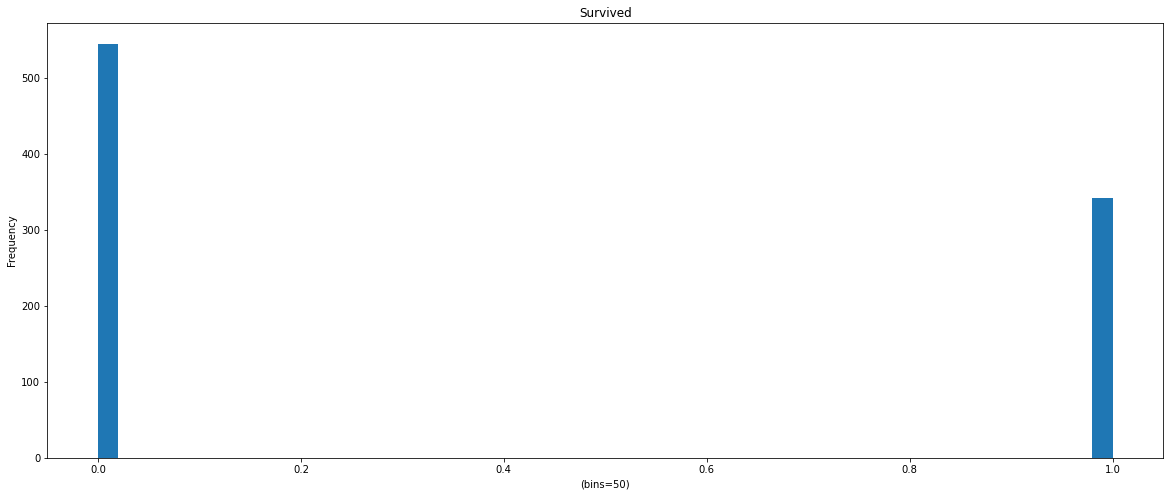

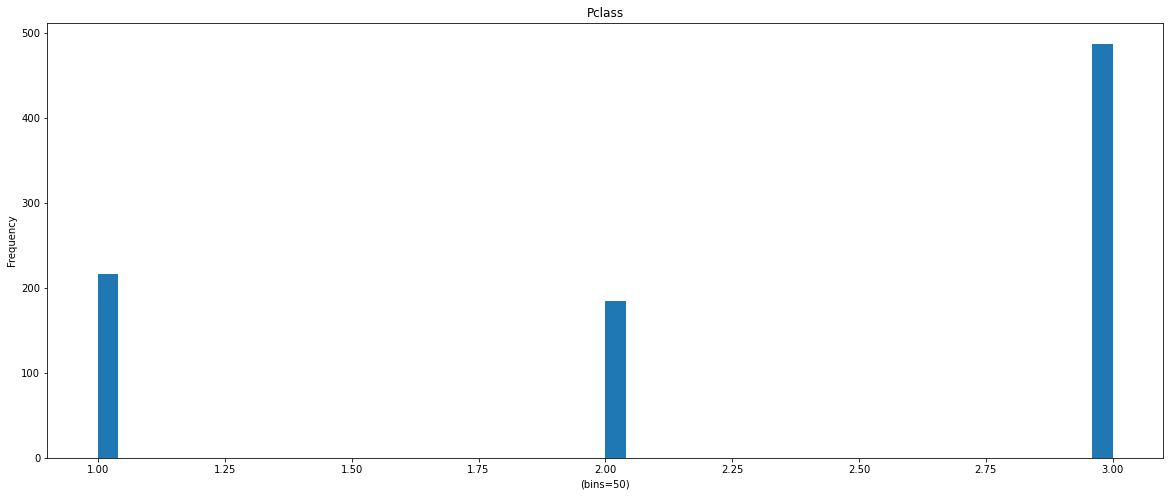

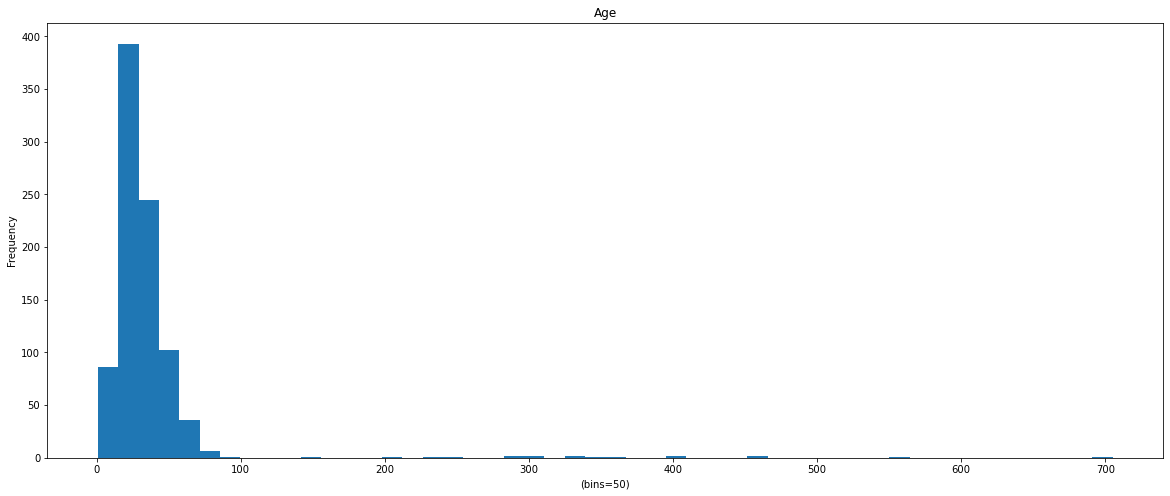

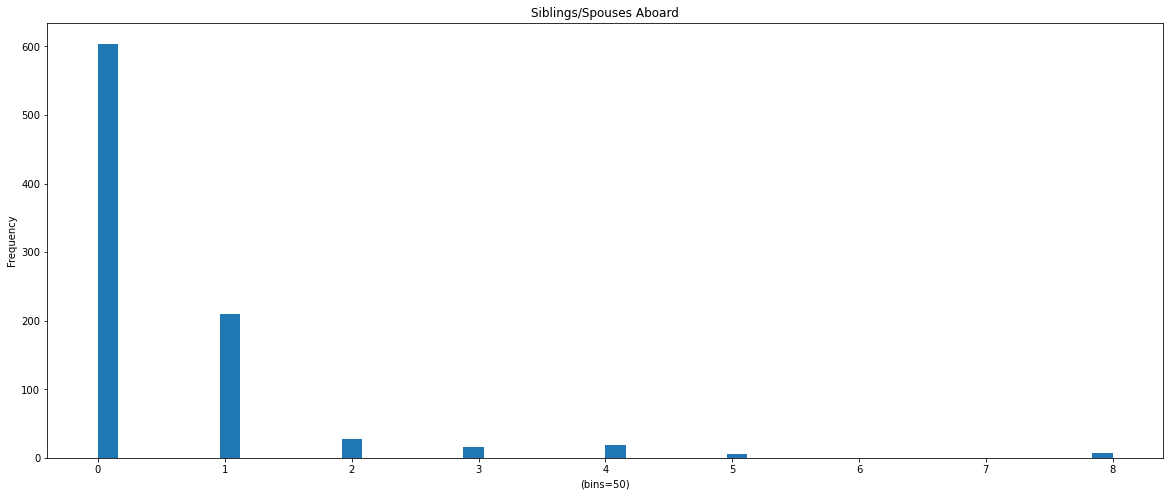

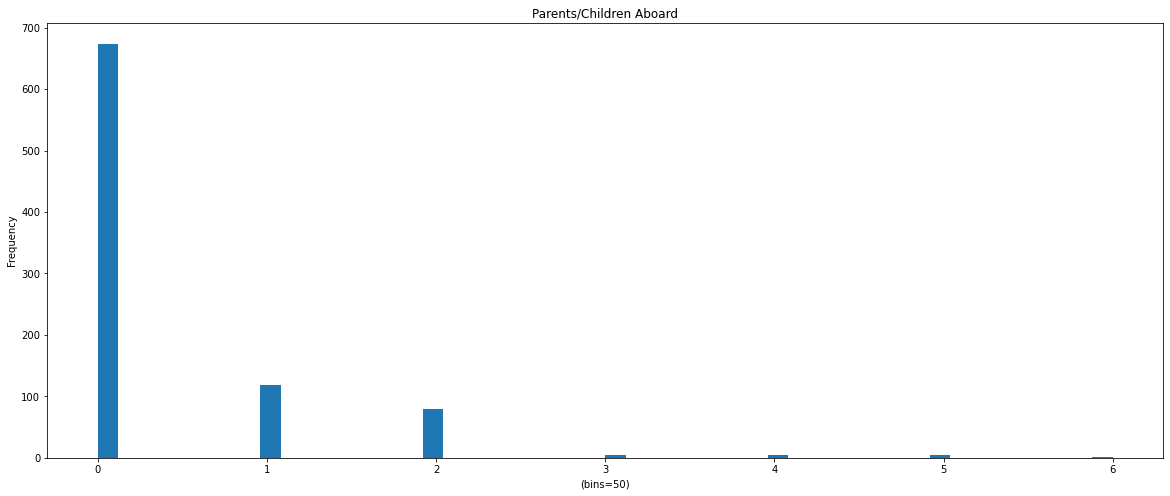

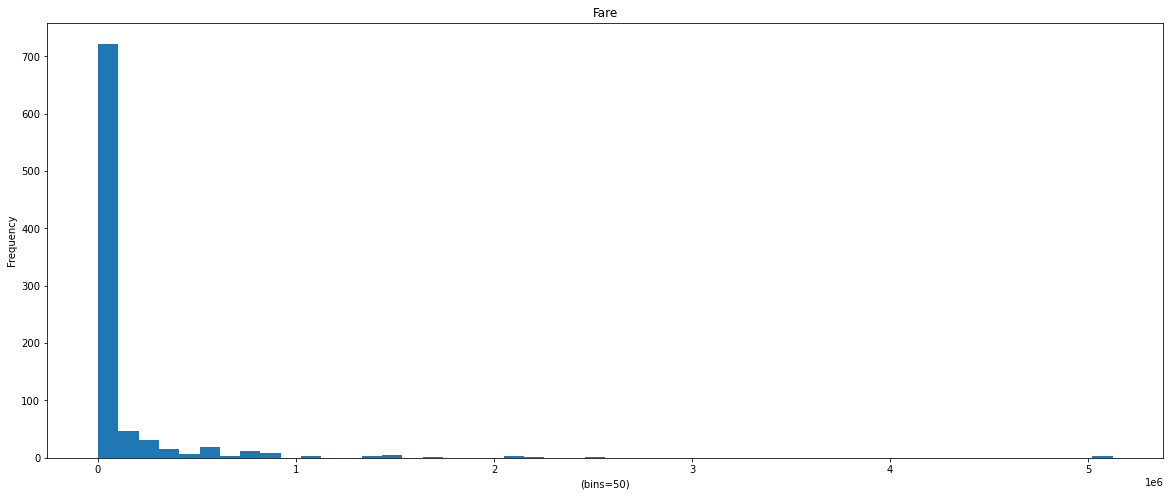

In [85]:
visualizer.plot_hist(df_numeric)

In [107]:
a = {"aa":{"x":1, "y":2},"bb":{"asd":5, "asd":7}}
for a in a.keys():
    print(a)

aa
bb
